In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pywt.data
import sys
import cv2

if '..' not in sys.path:
    sys.path.append('..')

from stego.transform import blocking, dwt
from stego import encoder

In proposed MDLE-IWT method, 
1. IWT is first appliedto the cover image to obtain four wavelet coefficient sub-bands asembedding regions.
1. The embedding sub-bands order in the algorithm is HL, LH, HH, and LL. 
1. Next, the embedding sub-band is divided into 3×3 non-overlapping blocks
1. MDLE scheme is applied to each block


In [2]:
original = pywt.data.camera()
original = blocking.pad_image(original, 5)
iwt = dwt.Iwt('haar', level=2)

In [3]:
iwt.forward(original)
secret_message = "Secret message to be saved"

In [4]:
decimal_message = encoder.message_to_dec(secret_message)
detail_coefficients: list[np.ndarray] = list(iwt.coefficients[-1])
ll = iwt.coefficients[0]

In [5]:

message_iterator = iter(decimal_message)

ll_blocks = blocking.divide_image(ll, block_size=3)


for band in detail_coefficients:
    blocks = blocking.divide_image(band, block_size=3)
    encoder.encode_band(blocks, message_iterator)


In [6]:
iwt.coefficients[-1] = tuple(detail_coefficients)

stego_img = iwt.inverse()
stego_img.shape

(516, 516)

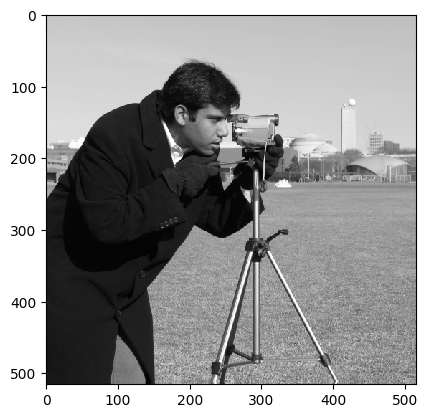

In [7]:

plt.imshow(stego_img, interpolation="nearest", cmap=plt.cm.gray)
# cv2.imwrite("comp.jpg", stego_img)
# img = cv2.imread("comp.jpg")
# stego_img, g, b = cv2.split(img)
# stego_img.shape

## Extracting

In [8]:
stego_img = blocking.pad_image(stego_img, 3)
# extract
iwt.forward(stego_img)
detail_coefficients = iwt.coefficients[-1]

detail_coefficients_blocks = [blocking.divide_image(coeff, block_size=3) for coeff in detail_coefficients]


In [9]:
encoded_data = []
for i, band in enumerate(detail_coefficients_blocks):
    for j, row in enumerate(band):
        for k, block in enumerate(row):
            encoded_data.extend(encoder.extract(block))


In [10]:
message = encoder.dec_to_message(encoded_data)

In [11]:
message[:50]

'Secret message to be saved\x00\x00"\n"\x00"\x00("" (\x02\x00 *\x08\n *\x00\n\x00'